This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

# 1. Import Libraries

Contains used libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt

# For Visualization Needs
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# For Feature Engineering
from sklearn.model_selection import train_test_split

# 2. Data Loading

The process involves preparing data before conducting further data exploration. Data Loading may include checking the dataset's size, etc.

In [2]:
# Load Data
data = pd.read_excel('Online_Retail.xlsx')

## Data Information

In [3]:
# Show All Data
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [4]:
# Show Data Information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The displayed data contains 8 columns and 541,908 rows, there are 1 column of datetime64 type, 2 columns of float64 type, 1 column of int64 type, and 4 columns object type.

| Column Name | Data Type | Description |
|---|---|---|
| `InvoiceNo` | object | a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation |
| `StockCode` | object | a 5-digit integral number uniquely assigned to each distinct product |
| `Description` | object | product name |
| `Quantity` | int64 | the quantities of each product (item) per transaction |
| `InvoiceDate` | datetime64[ns] | the day and time when each transaction was generated |
| `UnitPrice` | float64 | product price per unit |
| `CustomerID` | float64 | a 5-digit integral number uniquely assigned to each customer |
| `Country` | object | the name of the country where each customer resides |

# 3. Exploratory Data Analysis (EDA)

# 4. Feature Engineering

## 4.1 Pra-processing Data

### A. Checking Missing Values

In [5]:
# Missing Values Check
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

### B. Checking Data Duplicate 

In [6]:
# Checking data duplicate
data.duplicated().sum()

5268

In [7]:
# Dictionary saving results
columns_with_duplicates = {}

# Iteration each columns for checking data duplicate
for column in data.columns:
    if data[column].duplicated().any():  # Cek jika ada duplikat di kolom tersebut
        columns_with_duplicates[column] = True
    else:
        columns_with_duplicates[column] = False

# Show columns with data duplicate
for column, has_duplicates in columns_with_duplicates.items():
    if has_duplicates:
        print(f"Kolom '{column}' have data dupicate.")
    else:
        print(f"Kolom '{column}' don't have data duplicate.")

Kolom 'InvoiceNo' have data dupicate.
Kolom 'StockCode' have data dupicate.
Kolom 'Description' have data dupicate.
Kolom 'Quantity' have data dupicate.
Kolom 'InvoiceDate' have data dupicate.
Kolom 'UnitPrice' have data dupicate.
Kolom 'CustomerID' have data dupicate.
Kolom 'Country' have data dupicate.


# Exploratory Data Anlysis (EDA)

## Analisis Waktu Pembelian

Menentukan jam atau hari dalam seminggu ketika pelanggan paling sering melakukan pembelian, untuk mengoptimalkan waktu pengiriman email marketing atau promosi.

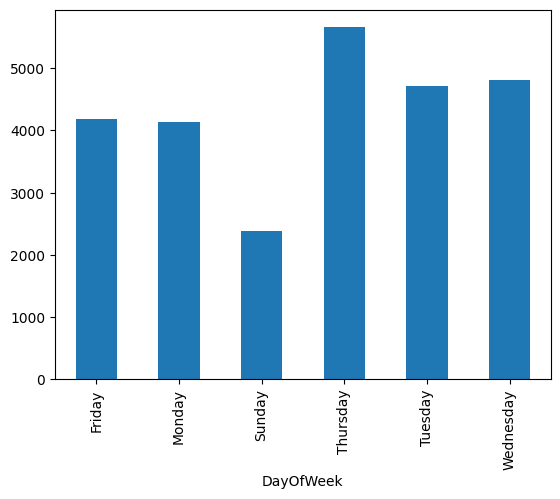

In [19]:
# Ekstrak hari dan jam dari InvoiceDate
data['Hour'] = data['InvoiceDate'].dt.hour
data['DayOfWeek'] = data['InvoiceDate'].dt.day_name()

# Menghitung jumlah faktur per jam dan hari
hourly_sales = data.groupby('Hour')['InvoiceNo'].nunique().plot(kind='bar')
daily_sales = data.groupby('DayOfWeek')['InvoiceNo'].nunique().plot(kind='bar')

Text(0.5, 1.0, 'Jumlah Pembelian per Hari')

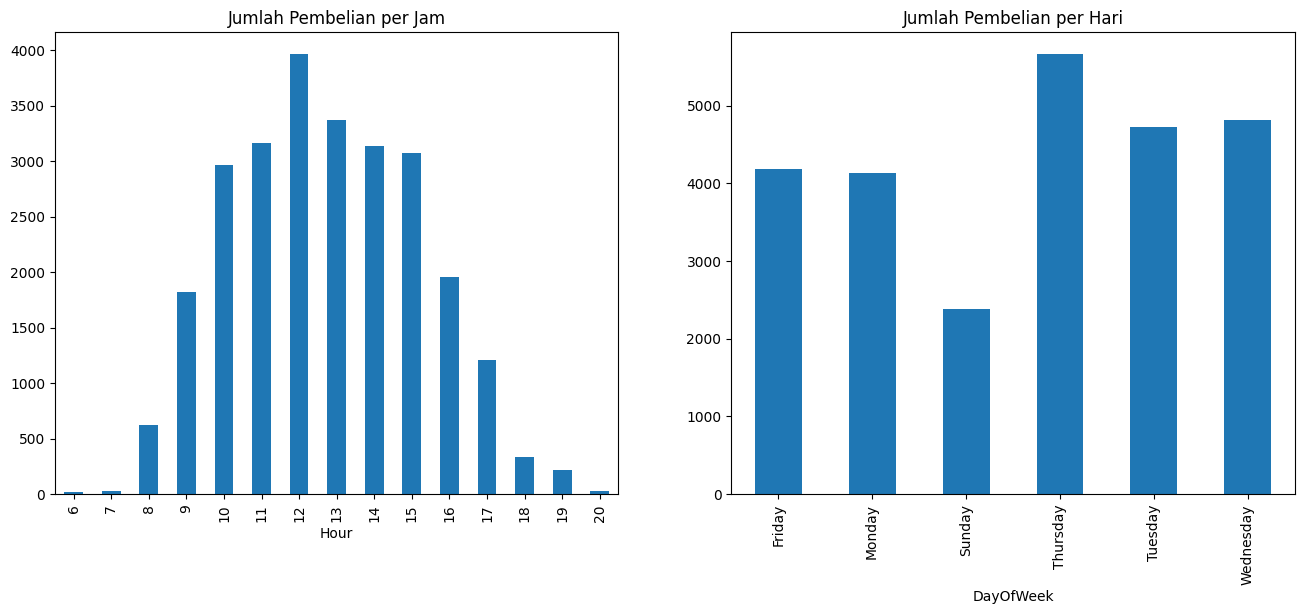

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
data.groupby('Hour')['InvoiceNo'].nunique().plot(kind='bar', ax=ax[0])
ax[0].set_title('Jumlah Pembelian per Jam')
data.groupby('DayOfWeek')['InvoiceNo'].nunique().plot(kind='bar', ax=ax[1])
ax[1].set_title('Jumlah Pembelian per Hari')

## Analisis Retensi Pelanggan

Menentukan seberapa sering pelanggan kembali untuk melakukan pembelian lain setelah pembelian pertama mereka, untuk mengukur loyalitas pelanggan

<Axes: ylabel='Frequency'>

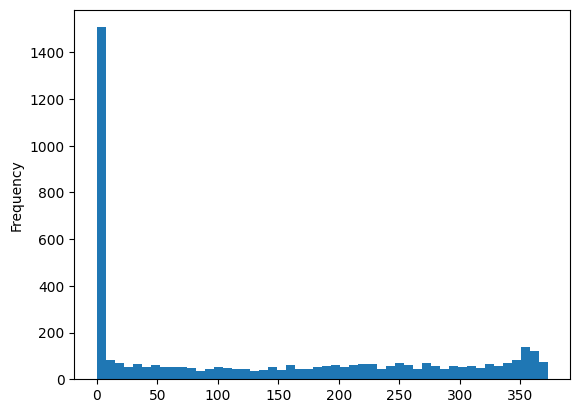

In [26]:
# Membuat kolom yang menunjukkan waktu pembelian pertama
data['FirstPurchase'] = data.groupby('CustomerID')['InvoiceDate'].transform('min')

# Menghitung selisih antara setiap pembelian dengan pembelian pertama
data['DaysSinceFirstPurchase'] = (data['InvoiceDate'] - data['FirstPurchase']).dt.days

# Analisis distribusi DaysSinceFirstPurchase untuk melihat pola retensi
retention_analysis = data.groupby('CustomerID')['DaysSinceFirstPurchase'].max().reset_index()
retention_analysis['DaysSinceFirstPurchase'].plot(kind='hist', bins=50)

Text(0.5, 1.0, 'Distribusi Hari Sejak Pembelian Pertama')

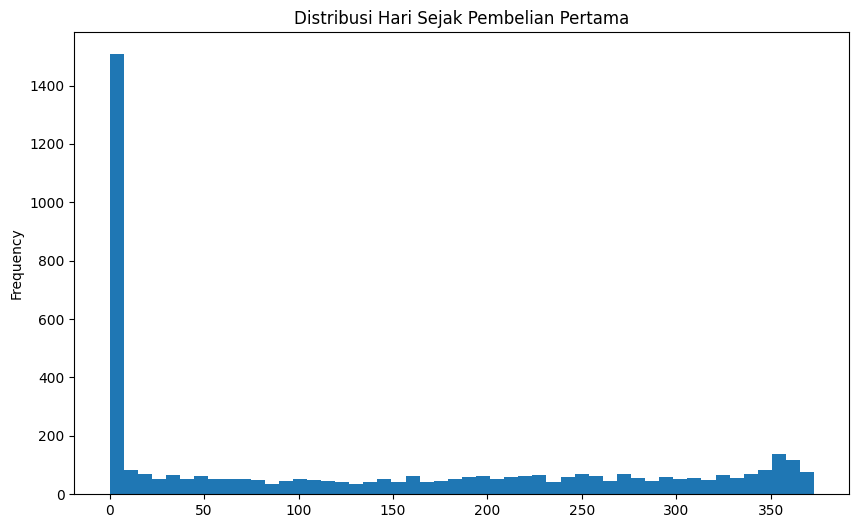

In [27]:
retention_analysis['DaysSinceFirstPurchase'].plot(kind='hist', bins=50, figsize=(10, 6))
plt.title('Distribusi Hari Sejak Pembelian Pertama')